In [1]:
import sys

import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import utils
from network import FourHeadedInception
from batch_generator import TwoMnistBatch
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST
from dataset.models.tf import Inception_v4

In [2]:
dset = MNIST(batch_class=TwoMnistBatch)

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting ExtractingExtracting/tmp/t10k-images-idx3-ubyte.gz  
/tmp/t10k-labels-idx1-ubyte.gz/tmp/train-labels-idx1-ubyte.gz



In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .gluing_of_images()
       .colorize_images(colors=[[0., 0., 1.], [0., 1., 0.]]))

In [4]:
inputs_config = {'images': {'shape':(128, 256, 3)},
                 'labels':{'shape':(2)},
                 'fir_col': {'classes':(2), 'transform': 'ohe', 'name':'first_color'},
                 'sec_col': {'classes':(2), 'transform': 'ohe', 'name':'second_color'},
                 'first': {'classes':(10), 'transform': 'ohe', 'name':'first_number'},
                 'second': {'classes':(10), 'transform': 'ohe', 'name':'second_number'}}

config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images',
          'head/color_importance': 1.}

four_headed_dict = {'images': B('images'),
                    'labels': B('labels'),
                    'fir_col': B('first_color'),
                    'sec_col': B('second_color'),
                    'first': B('first_number'),
                    'second': B('second_number')}

In [5]:
four_train_ppl = ((ppl<<dset.train)
                    .init_model('dynamic',
                                FourHeadedInception,
                                'fourinception',
                                config=config)
                   .train_model('fourinception',
                                feed_dict=four_headed_dict))

four_test_ppl = ((ppl<<dset.test)
                   .import_model('fourinception', four_train_ppl)
                   .init_variable('loss_c1', init_on_each_run=list)
                   .init_variable('loss_c2', init_on_each_run=list)
                   .init_variable('loss_n1', init_on_each_run=list)
                   .init_variable('loss_n2', init_on_each_run=list)
                   .predict_model('fourinception',
                                 fetches=['FourHeadedInception/loss_c1:0',
                                         'FourHeadedInception/loss_c2:0',
                                         'FourHeadedInception/loss_n1:0',
                                         'FourHeadedInception/loss_n2:0'],
                                 feed_dict=four_headed_dict,
                                 save_to=[V('loss_c1'),
                                         V('loss_c2'),
                                         V('loss_n1'),
                                         V('loss_n2')],
                                 mode='a'))

../utils.py:297: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  axis[1].plot(ewma(np.array(loss), span=10, adjust=False), label='%s'%name)
../utils.py:298: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  axis[0].plot(ewma(np.array(loss[-100:]), span=10, adjust=False), label='%s'%name)


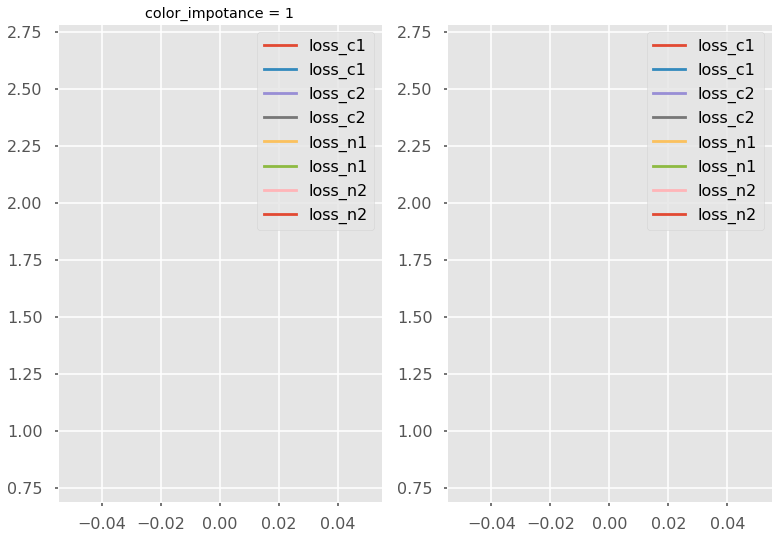

KeyboardInterrupt: 

In [6]:
names = ['loss_c1', 'loss_c2', 'loss_n1', 'loss_n2']

for i in tqn(range(1000)):
    four_train_ppl.next_batch(24, n_epochs=None, shuffle=True)
    four_test_ppl.next_batch(24, n_epochs=None, shuffle=True)
    if i%10==0:
        clear_output(True)
        losses = np.array([four_test_ppl.get_variable(name) for name in names])
        utils.four_losses_draw(losses, names, 'color_impotance = 1')
        if np.mean(np.sum(losses[:, -30::], axis=0)) < 0.2:
            break
global_loss.append(losses)

In [7]:
four_headed_test = ((ppl<<dset.test)
                    .init_variable('first_color', init_on_each_run=list)
                    .init_variable('second_color', init_on_each_run=list)
                    .init_variable('first_num', init_on_each_run=list)
                    .init_variable('second_num', init_on_each_run=list)
                    .init_variable('loss', init_on_each_run=list)
                    .import_model('fourinception', four_train_ppl)
                    .predict_model('fourinception', 
                                   fetches=['FourHeadedInception/first_color:0', 
                                            'FourHeadedInception/second_color:0',
                                            'FourHeadedInception/first_number:0',
                                            'FourHeadedInception/second_number:0',
                                            'loss'],
                                   feed_dict=four_headed_dict,
                                   save_to=[V('first_color'),
                                            V('second_color'), 
                                            V('first_num'), 
                                            V('second_num'),
                                            V('loss')], mode='a'))

In [8]:
colors_true = []
numbers_true = []

In [9]:
for i in tqn(range(1)):
    batch = four_headed_test.next_batch(100)
    loss = four_headed_test.get_variable('loss')

    first_color = four_headed_test.get_variable('first_color')
    second_color = four_headed_test.get_variable('second_color')
    first_num = four_headed_test.get_variable('first_num')
    second_num = four_headed_test.get_variable('second_num')

    if len(colors_true) != 0: 
        colors_true = np.hstack((colors_true, np.hstack((batch.first_color, batch.second_color))))
        numbers_true = np.hstack((numbers_true, np.hstack((batch.first_number, batch.second_number))))
    else:
        colors_true = np.hstack((batch.first_color, batch.second_color))
        numbers_true = np.hstack((batch.first_number, batch.second_number))

    colors_pred = np.hstack((first_color, second_color)).reshape(-1, 2)
    numbers_pred = np.hstack((first_num, second_num)).reshape(-1, 10)

Widget Javascript not detected.  It may not be installed or enabled properly.


сделать true-positive and true-negative. На что сетка переобучилась и тд.

Accuracy on colors: 0.610 
Accuracy on numbers: 0.135


(array([ 15.,   9.,  11.,  23.,  29.,  20.,  17.,  21.,  15.,  13.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

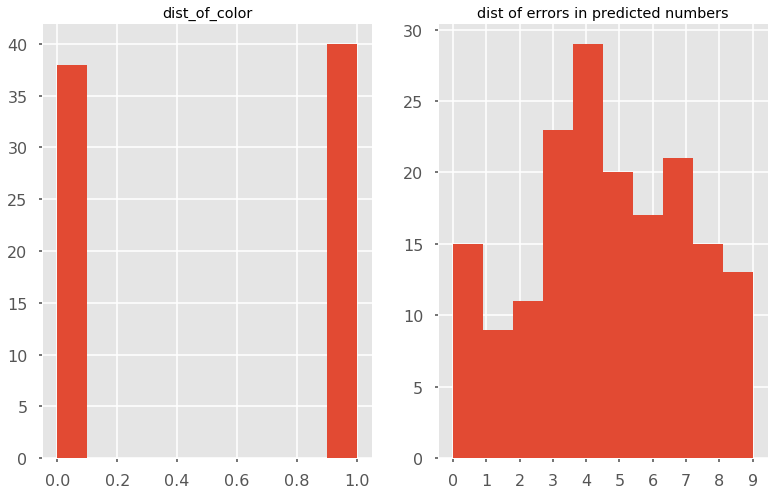

In [10]:
wrong_num, acc_num, wrong_col, acc_col = np.array(list(utils.class_accuracy([numbers_pred,colors_pred], \
                                                                            [numbers_true,colors_true], \
                                                                            [10, 2]))).reshape(-1)
print('Accuracy on colors: %.3f'%acc_col, '\nAccuracy on numbers: %.3f'%acc_num)

_, subplot = plt.subplots(1, 2, figsize=(13, 8))
subplot[0].set_title('dist_of_color')
if len(wrong_col) == 0:
    print('No errors in color')
else:
    subplot[0].hist(wrong_col)
subplot[1].set_title('dist of errors in predicted numbers')
plt.setp(subplot[1], xticks=range(10))
subplot[1].hist(wrong_num)

In [11]:
config =  {'inputs': {'images': {'shape': (128, 128, 1)},
                      'labels': {'classes': (10),
                                 'transform': 'ohe',
                                 'dtype': 'int64',
                                 'name': 'targets'}},
          'input_block/inputs': 'images',
          'loss': 'softmax_cross_entropy',
          'optimizer': 'Adam',
          'output': dict(ops=['proba', 'accuracy'])}

train_ppl = (dset.train.p
                 .resize(shape=(128, 128))
                 .init_model('dynamic',
                             Inception_v4,
                             'inception_v4',
                             config=config)
                 .train_model('inception_v4',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')}))
test_ppl = (dset.test.p
                .resize(shape=(128, 128))
                .init_variable('loss', init_on_each_run=list) 
                .import_model('inception_v4', train_ppl)
                .predict_model('inception_v4',
                               fetches='loss',
                               feed_dict={'images': B('images'),
                                         'labels': B('labels')},
                               save_to=V('loss'), mode='a'))

../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)


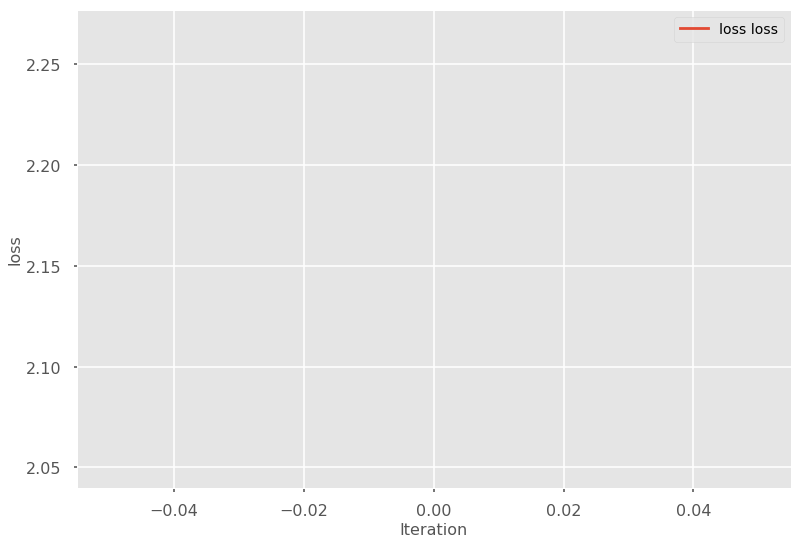

KeyboardInterrupt: 

In [12]:
for i in tqn(range(1000)):
    train_ppl.next_batch(24, n_epochs=None, shuffle=True)
    test_ppl.next_batch(24, n_epoths=None, shuffle=True)
    if i%10==0:
        clear_output(True)
        losses = test_ppl.get_variable('loss')
        utils.draw(losses, 'loss')
        plt.show()
        if np.mean(losses[-30:]) <= 0.2:
            break

In [13]:
pred_ppl = (dset.test.p
           .resize(shape=(128, 128))
           .init_variable('predictions', init_on_each_run=list)
           .import_model('inception_v4', train_ppl)
           .predict_model('inception_v4',
                          fetches='output_proba',
                          feed_dict={'images': B('images'),
                                     'labels': B('labels')},
                          save_to=V('predictions'), mode='a'))
real = []
for i in tqn(range(1)):
    batch = pred_ppl.next_batch(100, n_epochs=None, shuffle=True)
    predict = np.array(pred_ppl.get_variable('predictions'))
    real.append(np.array(batch.labels))
real = np.array(real).reshape(-1)
predict = predict.reshape(-1, 10)

Widget Javascript not detected.  It may not be installed or enabled properly.


(array([  9.,  12.,  12.,   9.,   6.,   9.,   8.,  13.,   0.,   9.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

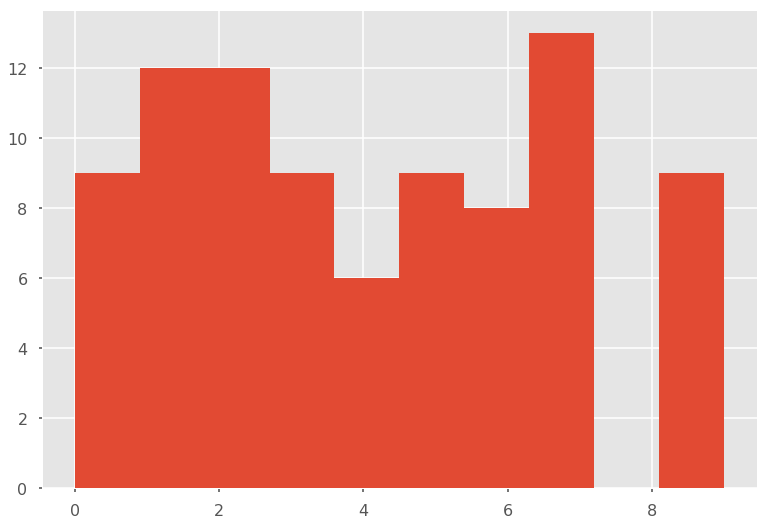

In [14]:
dist, acc = np.array(list(utils.class_accuracy([predict], [real], [10]))[0])
plt.hist(dist)

(array([   87.,     0.,     0.,     0.,     0.,  1060.,     0.,     0.,
            0.,   645.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

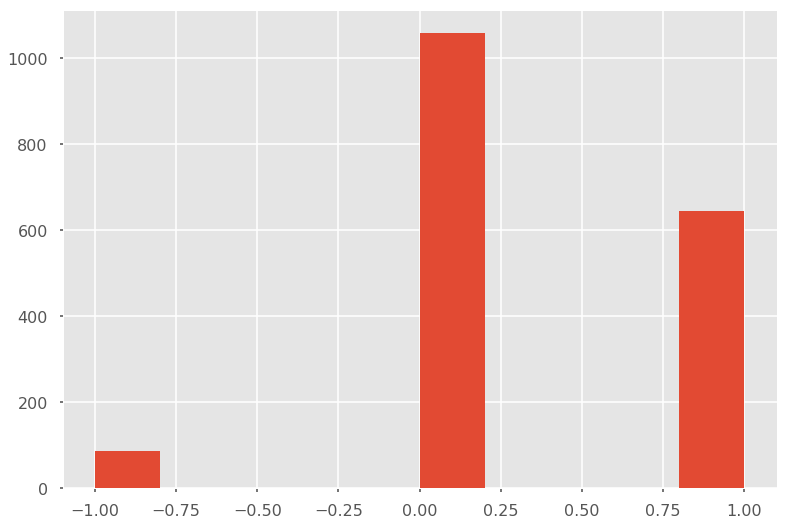

In [30]:
diff_dist = np.sort(wrong_num) - np.sort(dist[:1792])
plt.hist(diff_dist)